In [1]:
using Plots
include("src/Trajectories.jl")
using .QuTaM

In [2]:
using DifferentialEquations

In [3]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - delta*r[2]
    dr[2] = delta*r[1] - 0.5*gamma*r[2] - omega*r[3]
    dr[3] = omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [4]:
r0 = [0.0; 0.0; 1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000))
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [5]:
# Steady State
gamma = QuTaM.rf_gamma
delta = QuTaM.rf_delta
omega = QuTaM.rf_omega
r_steady = 1/(gamma^2 + 2*omega^2+4*delta^2) * [-4*delta*omega; 2*omega*gamma;-gamma^2-4*delta^2 ]

3-element Vector{Float64}:
 -0.04134561172711897
  0.20672805863559482
 -0.9772599135500846

In [9]:
################## Average Simulation ################3
using LinearAlgebra
using Statistics
# 1. Sample the trajectories
data_labels = QuTaM.run_trajectories(sys, params)
# 2. Obtain the states at the given times
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = Array{ComplexF64}(undef, params.ntraj, ntimes, sys.NLEVELS );
for n in 1:params.ntraj
        sample[n, :, :] = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
end
accepted_error = 0.1 # Accept a relative accumulated error of up to 10%
# Obtain the observable on the sample.
r_sample = zeros(Float64, params.ntraj, ntimes, 3)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]
for j in 1:3
    for tn in 1:ntimes
        for k in 1:params.ntraj 
                r_sample[k, tn, j] = dot(sample[k, tn, :], sigma[j] * sample[k, tn, :])   # Drop the extra dimension
        end
    end
end 
# Average
r_avg = dropdims(mean(r_sample, dims=1), dims=1);

In [11]:
params

SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=50000
seed=1
ntraj=1000)
multiplier=5.0
tf=1.0
dt=0.0001
eps=0.001)

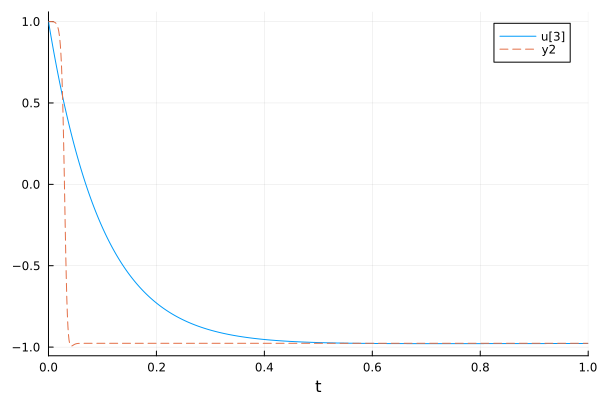

In [10]:
plot(sol, idxs=[(0,3)])
plot!(t_given, r_avg[:,3], line=:dash)